In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as matimg
import tensorflow as tf
from tensorflow import keras
from skimage import transform
import os
import imageio
import PIL
import time

C:\Users\hashi\AppData\Local\Temp\ipykernel_17788\3279896831.py:20: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = transform.rescale(img, scale, multichannel=True)


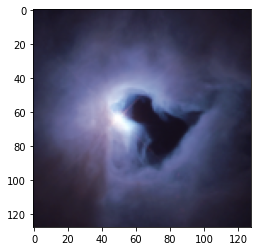

dimensions:
row: 128px col: 128px


In [2]:
# util functions for reading .tif/.png imgs

# takes a path for a .png format img and returns it as a np.ndarray
def read_img(path: str):
    try:
        img = plt.imread(path)
        return img
        
    except FileNotFoundError:
        print(f'unable to read path: {path} from the current directory')
        raise FileNotFoundError

# crop/resize .png format img to n x n x 3 img 
# default n = 256 so imgs are reformated to row: 128 col: 128 channels: 3 
def resize_img(img: np.ndarray, n: int=128):
    try:
        row, col, ch = img.shape

        scale = max(n / row, n / col)
        img = transform.rescale(img, scale, multichannel=True)
        return img[:n, :n, :]

    except:
        return f'unable to resize {*img.shape,} to 128, 128, 4'


# void function to graph a .png img to a matplotlib plot
def display_img(img: np.ndarray):
    plt.imshow(img)
    plt.show()

    row, col, ch = img.shape
    print(f'dimensions:\nrow: {row}px col: {col}px')

# example for reading and resizing a .png image from hubble_imgs and graphing it
img = read_img(r'./hubble_imgs_fixed/opo0010a.png')
img = resize_img(img)
display_img(img)


In [3]:
# UNPROCESSED DATA FROM KAGGLE: https://www.kaggle.com/datasets/redwankarimsony/top-100-hubble-telescope-images?resource=download
# had to delete some of the larger imgs from the dataset

# process training data from m,n,3 .tif imgs to 128,128,3 png imgs 
# commented out because i alr processed the data and deleted ./hubble_imgs 
# .tif img directory because it was taking up 4gbs of space
# for path in os.listdir(r'./hubble_imgs'):
#     read, write = os.path.join('hubble_imgs', path), os.path.join('hubble_imgs_fixed', path[:-4] + '.png')

#     img = resize_img(read_img(read))
#     matimg.imsave(write, img)

# resizing images to 128, 128, 4 because 256, 256, 4 was too large
# for path in os.listdir(r'./hubble_imgs_fixed'):
#     read, write = os.path.join('./hubble_imgs_fixed', path), os.path.join('./hubble_imgs_fixed', path)

#     img = resize_img(read_img(read))
#     matimg.imsave(write, img)

C:\Users\hashi\AppData\Local\Temp\ipykernel_17788\3279896831.py:20: FutureWarning: `multichannel` is a deprecated argument name for `rescale`. It will be removed in version 1.0. Please use `channel_axis` instead.
  img = transform.rescale(img, scale, multichannel=True)


In [4]:
# reformating data into a csv *not really ideal the csv is very large so not really useable
# function which returns the csv header
def csv_header():
    repr = ''

    for row in range(128):
        for col in range(128):
            for channel in ('r', 'g', 'b', 'a'):
                repr += f'{row}x{col}{channel},'

    return repr[:-1]



# read data from directory *dirname into a formated processed csv
def imgs_to_csv(dirname: str, dest: str='hubble_data.csv'):
    try:
        # append each flattened img in hubble_img_fixed to hubble_imgs.csv file 
        with open(dest, 'ab') as csvstream:
            for img in os.listdir(dirname):
                img = read_img(os.path.join(dirname, img))
                # each channel *rgb has px values ranging from 0 to 1 as a floating pt num i.e x.xxxxxx
                np.savetxt(csvstream, img.reshape(1,128*128*4), fmt='%1.6f', delimiter=',') 

    
    except FileNotFoundError:
        print(f'unable to find directory: {dirname}')

# imgs_to_csv('./hubble_imgs_fixed')
# img_df = pd.DataFrame(read_img('./hubble_imgs_fixed/opo0010a.png')[:, :, 0])
# print(img_df)
# print(csv_header())

In [5]:
# reads training/sample data to a ndarray and sets hyperparameters 
BUFFER_SIZE = 99
BATCH_SIZE = 11

dirname = './hubble_imgs_fixed/'
imgs = []

for basename in os.listdir('./hubble_imgs_fixed'):
    cur = plt.imread(f'{dirname}{basename}', format='png')
    imgs.append(cur)

TRAIN = np.array(imgs)
np.random.shuffle(TRAIN)
print(TRAIN.shape)

(96, 128, 128, 4)


In [8]:
# discriminator/classifier function for the gan
# downsamples and maxpools 128, 128, 4 tensors representing rgba imgs to a probability between 0 and 1 that the img is real
def make_discriminator(img_dim=(128, 128, 4), num_filters=64, num_layers=7):
    model = keras.Sequential()

    # input/img layer 128, 128, 4 tensor with values in range [0, 1]
    model.add(keras.layers.Input(shape=img_dim))

    # hidden convolutional layers downscale tensor/img to range [0, 1]
    for _ in range(num_layers):
        model.add(keras.layers.Conv2D(num_filters, kernel_size=4, strides=2, padding='same'))
        model.add(keras.layers.BatchNormalization())
        model.add(keras.layers.LeakyReLU(alpha=0.3))

    # output layer probability in range [0, 1] that img is real or fake
    model.add(keras.layers.GlobalAveragePooling2D())
    model.add(keras.layers.Dense(1, activation='sigmoid'))

    return model


batch, row, col, channels: (1, 128, 128, 4)
min: -0.0012177596800029278
max: 0.0009647210827097297
untrained decision: [[0.49999973]]


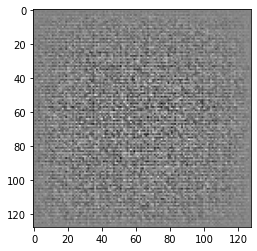

In [7]:
# generator function for the gan
# upsamples a normally distributed 100, 1 tensor to 256, 256, 4 tensors representing rgba img
def make_generator(latent_dim=(1, 100), num_filters=64, num_layers=6):
    model = keras.Sequential()

    # input/latent layer 100, 1 tensor with values normally distributed in the range [0, 1]
    latent_row, latent_col = latent_dim
    model.add(keras.layers.Dense(latent_col, input_dim=latent_col))
    model.add(keras.layers.LeakyReLU(alpha=0.3))
    model.add(keras.layers.Reshape((1, 1, latent_col)))

    # num_layers hidden convolutional layers to upsample image to 256, 256, 4 rgba img
    for _ in range(num_layers):
        model.add(keras.layers.Conv2DTranspose(num_filters, kernel_size=4, strides=2, padding='same'))
        model.add(keras.layers.LeakyReLU(alpha=0.3))
        num_filters *= 2

    # output layer
    model.add(keras.layers.Conv2DTranspose(4, kernel_size=4, strides=2, padding='same', activation='tanh'))

    return model


# making discriminator and generator models
# currently untrained
generator = make_generator()
discriminator = make_discriminator()

noise = tf.random.normal([1, 100])
generated_image = generator(noise, training=False)
print(f'batch, row, col, channels: {*generated_image.shape,}')
print(f'min: {np.min(generated_image)}\nmax: {np.max(generated_image)}')
print(f'untrained decision: {discriminator(generated_image)}')
plt.imshow(generated_image[0, :, :, 0], cmap='gray')

In [9]:
# referece to understand whats going on: https://www.tensorflow.org/tutorials/generative/dcgan
# function to make the dcgan
# default to using a generator which takes a normally distributed 1, 100 tensor and creates rgba imgs of dim 1, 256, 256, 4
# default to using a discriminator which takes a rgba img of dim 1, 256, 256, 4 and returns a probability in the range [0, 1]

# this method returns a helper function to compute cross entropy loss
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = keras.optimizers.Adam(1e-4)
discriminator_optimizer = keras.optimizers.Adam(1e-4)


In [16]:
# trains the dcgan
# sets up checkpoints to train gan over multiple sessions
ckpt_dir = './training_checkpoints'
ckpt_path = os.path.join(ckpt_dir, "ckpt")
checkpoint = tf.train.Checkpoint(
  generator_optimizer=generator_optimizer, 
  discriminator_optimizer=discriminator_optimizer,
  generator=generator,discriminator=discriminator
  )
ckpt_manager = tf.train.CheckpointManager(checkpoint, ckpt_path, max_to_keep=4)
checkpoint.restore(ckpt_manager.latest_checkpoint)

EPOCHS = 4
LATENT_DIM = 100
NUM_EXAMPLES = 4
seed = tf.random.normal([NUM_EXAMPLES, LATENT_DIM])

# tf decorator to compile the function to speed up training
@tf.function
def train_step(data):
  noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    generated_images = generator(noise, training=True)

    real_output = discriminator(data, training=True)
    fake_output = discriminator(generated_images, training=True)

    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

# def generate_and_save_images(model, epoch, test_input):
#   # notice `training` is set to False.
#   # this is so all layers run in inference mode (batchnorm).
#   predictions = model(test_input, training=False)

#   fig = plt.figure(figsize=(4, 4))

#   for i in range(predictions.shape[0]):
#       plt.subplot(4, 4, i+1)
#       plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
#       plt.axis('off')

#   plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
#   plt.show()


def train(dataset, epochs, batches=9):
  for epoch in range(epochs):
    start = time.time()

    for i in range(batches):
      train_step(TRAIN[i:i+BATCH_SIZE, :, :, :])
      print(f'batch {i}: {time.time() - start}s')
      i += BATCH_SIZE

    # save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix=ckpt_path)

    print(f'time for epoch {epoch+1} is {time.time()-start} sec')

train(TRAIN, 15)


c:\Users\hashi\AppData\Local\Programs\Python\Python310\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


batch 0: 8.43331527709961s
batch 1: 16.813711881637573s
batch 2: 25.72851300239563s
batch 3: 34.5773389339447s
batch 4: 43.621094703674316s
batch 5: 52.538909673690796s
batch 6: 61.437580585479736s
batch 7: 70.40801548957825s
batch 8: 79.30117225646973s
time for epoch 1 is 79.30117225646973 sec
batch 0: 8.910677194595337s
batch 1: 17.952168703079224s
batch 2: 26.89897918701172s
batch 3: 35.852827310562134s
batch 4: 44.772045850753784s
batch 5: 53.7128119468689s
batch 6: 62.645366191864014s
batch 7: 71.64763855934143s
batch 8: 80.56127429008484s
time for epoch 2 is 80.56127429008484 sec
batch 0: 9.078072786331177s
batch 1: 18.112169981002808s
batch 2: 27.096817016601562s
batch 3: 36.386645555496216s
batch 4: 46.30331873893738s
batch 5: 57.329042196273804s
batch 6: 69.41139221191406s
batch 7: 84.28461623191833s
batch 8: 104.04079008102417s
time for epoch 3 is 104.04179215431213 sec
batch 0: 22.83731245994568s
batch 1: 45.53561568260193s
batch 2: 66.55337905883789s
batch 3: 82.46846055984

batch, row, col, channels: (1, 128, 128, 4)
min: -0.007746041752398014
max: 0.007654672488570213
untrained decision: [[0.519437]]


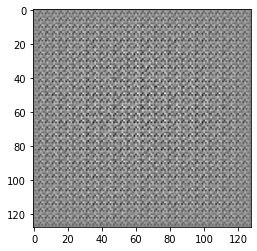

In [17]:
def generate_random():
    noise = tf.random.normal([1, 100])
    generated_image = generator(noise, training=False)
    print(f'batch, row, col, channels: {*generated_image.shape,}')
    print(f'min: {np.min(generated_image)}\nmax: {np.max(generated_image)}')
    print(f'untrained decision: {discriminator(generated_image)}')
    plt.imshow(generated_image[0, :, :, 0], cmap='gray')

generate_random()